In this notebook we will learn the basics of training Neural Network models using the pytorch-lightning library.

pytorch-lightning is a wrapper library that serves as an abstraction level library which makes the process much easier to learn and manage

we will start by importing some of the modules we will use:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns
import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")

import lightning as L
from torchvision import datasets
import torch
from torch import nn
from torchvision.transforms import ToTensor,Lambda
from torchvision import transforms
from torchmetrics import Accuracy
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader, random_split
from torchvision.io import read_image

c:\Users\nati\.conda\envs\lightning\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\nati\.conda\envs\lightning\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
c:\Users\nati\.conda\envs\lightning\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


As you can see torchvision comes with some builtin datasets. 

These are commonly used datasets for educational and research purposes, that have many implemented solutions and benchmark results

We will start as stated during the presentation with a simple dataset called MNIST

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.cuda.is_available()

True

In [4]:
mnist_train = datasets.MNIST(root='data', train=True, download=True,transform=ToTensor())
mnist_test = datasets.MNIST(root='data', train=False, download=True,transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:07<00:00, 1260903.56it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 186880.12it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1339312.84it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4046416.48it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [5]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

the following cell is for didactic purposes only and you're unlikely to perform this step on a large dataset after you already created a dataset (you'll somethimes do it before creating a dataset object)

In [6]:
X_train = np.array([np.array(mnist_train[i][0]) for i in range(len(mnist_train))])
X_test = np.array([np.array(mnist_test[i][0]) for i in range(len(mnist_test))])
y_train = np.array([np.array(mnist_train[i][1]) for i in range(len(mnist_train))])
y_test = np.array([np.array(mnist_test[i][1]) for i in range(len(mnist_test))])

In [7]:
len(mnist_train),len(mnist_test)

(60000, 10000)

In [8]:
X_train.shape

(60000, 1, 28, 28)

an alternative way to conduct the same directly from the dataset object would be:

In [21]:
print('the dataset contains',mnist_train.__len__(), 'examples')
print('each example size is:',mnist_train.__getitem__(0)[0].size())

the dataset contains 60000 examples
each example size is: torch.Size([1, 28, 28])


In [22]:
#lets look at the data:
print('X_train shape is: {} \n\
y_train shape is: {}'.format(X_train.shape,y_train.shape))
print()
print('X_test shape is: {} \n\
y_test shape is: {}'.format(X_test.shape,y_test.shape))

X_train shape is: (60000, 1, 28, 28) 
y_train shape is: (60000,)

X_test shape is: (10000, 1, 28, 28) 
y_test shape is: (10000,)


In [23]:
X_train[0]

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.

In [24]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

so our data consists of 60k training samples and 10k images each with 28x28 pixels

lets look at how a sample of them look like...

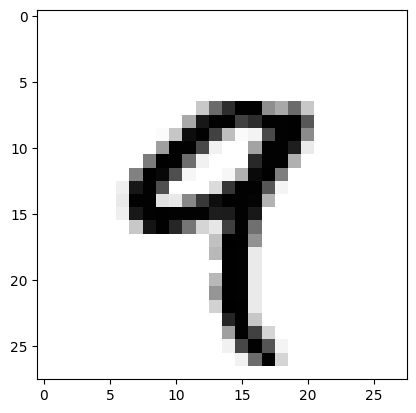

In [25]:
# plt.imshow(X_train[0])
plt.imshow(X_train[4].squeeze(),cmap='binary')


In order to get a better understanding of how a data set looks like we should usually take a look at multiple samples at once, this can be done with the following code which we will find useful for our result analysis as well

Note that the more information we can present on a single plot - the better we can understand and later communicate our results

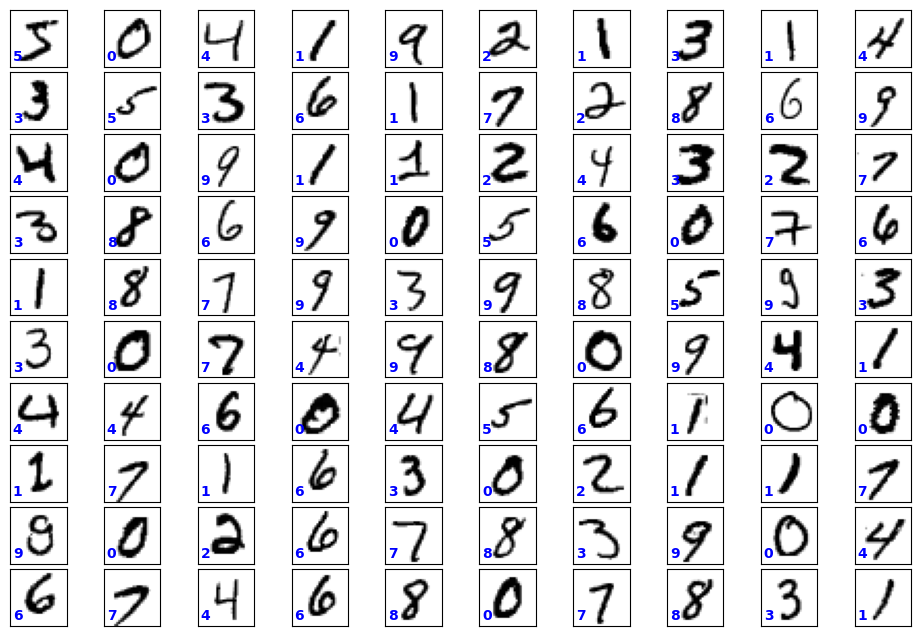

In [26]:
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(nrow*ncol):
        ax[i//ncol,i%ncol].imshow(X[skip+i].squeeze(),cmap='binary')
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.85, 0.1, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='green' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
    plt.show()
plot_multiple_imgs(X_train,y_train,10,10,(12,8))

(-0.5, 27.5, 27.5, -0.5)

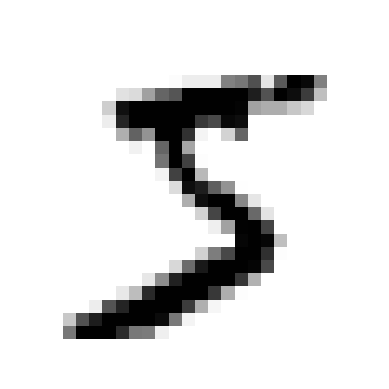

In [27]:
plt.imshow(X_train[0].squeeze(),cmap='binary')
plt.axis('off')

Before we start training a neural network classifier lets try to train two basic models from the ones we mentioned in the previous lecture
* a logistic regression classifier 
* a support vector classifier 

[[ 959    0    0    3    1    7    5    4    1    0]
 [   0 1112    4    2    0    2    3    2   10    0]
 [   6    9  928   16    8    4   15    7   35    4]
 [   4    1   17  921    0   23    4   11   23    6]
 [   1    1    7    4  914    0   10    4   10   31]
 [  10    2    3   37    8  779   14    5   29    5]
 [   9    3    7    3    8   15  910    2    1    0]
 [   1    9   23    6    7    1    0  950    2   29]
 [   9   10    8   26    8   26   12    7  857   11]
 [   9    8    0   11   23    6    0   19    7  926]]

model accuracy on test set is: 92.56%

Wall time: 25.6 s


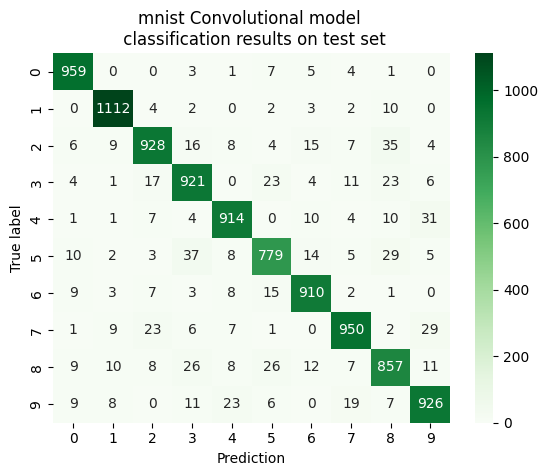

In [28]:
%%time

from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression(n_jobs=8,solver='lbfgs',multi_class='auto')
lrc.fit(X_train.reshape((60000,784)),y_train)
preds = lrc.predict(X_test.reshape((10000,784)))

pred_cat = preds
print(confusion_matrix(y_test,pred_cat))
print()
print('model accuracy on test set is: {}%'.format(accuracy_score(y_test,pred_cat)*100))
sns.heatmap(confusion_matrix(y_test,pred_cat),cmap='Greens',annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('mnist Convolutional model \n classification results on test set')
print()

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred_cat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.94      0.93      0.93       982
           5       0.90      0.87      0.89       892
           6       0.94      0.95      0.94       958
           7       0.94      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.92      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



[[ 968    0    1    1    0    3    3    2    2    0]
 [   0 1126    3    0    0    1    3    0    2    0]
 [   6    1  994    3    2    0    1   15    9    1]
 [   0    0    4  979    1    7    0   12    7    0]
 [   0    0   11    0  945    2    4    7    3   10]
 [   2    0    1   10    2  855    6    7    7    2]
 [   6    2    1    0    4    8  931    2    4    0]
 [   1    6   14    2    3    0    0  989    0   13]
 [   3    0    4    6    6   11    3   11  927    3]
 [   4    6    4   11   12    1    0   17    3  951]]

model accuracy on test set is: 96.65%

Wall time: 11min 35s


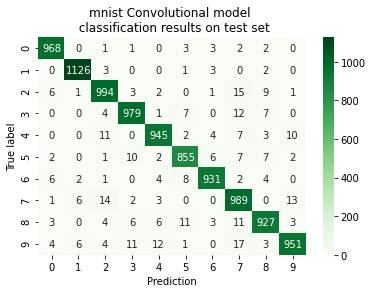

In [12]:
%%time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
# keep in mind we have to normalize our inputs!

stds = StandardScaler()
svc = SVC(max_iter=10000,gamma='auto')
svc.fit(stds.fit_transform(X_train[:60000].reshape((60000,784))),y_train[:60000])
preds = svc.predict(stds.transform(X_test.reshape((10000,784))))

pred_cat = preds
print(confusion_matrix(y_test,pred_cat))
print()
print('model accuracy on test set is: {}%'.format(accuracy_score(y_test,pred_cat)*100))
sns.heatmap(confusion_matrix(y_test,pred_cat),cmap='Greens',annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('mnist Convolutional model \n classification results on test set')
print()

### Now that we have a naive benchmark - lets define our first NN model!

we will use a type of model called "Sequential"

in this type of models we "stack" layers one on top of another so that each layer's output serves as the input of the next layer

In [31]:
import pandas as pd
import os

# in the example above we have read the dataset objects for both train and test directly 
# usually we will only get the data itself and we will have to form our own dataset classes and objects
# this is an example how to do it assuming we have a dataframe containing the file names and the labels 
class MNIST_dataset(Dataset):    
    def __init__(self,path_to_imgs,labels_file,transform=None,trarget_transform=None):
        ## assumptions:
        ## labels_file contains filename and label for that file
        self.labels = pd.read_csv(labels_file)
        self.path_to_imgs = path_to_imgs
        self.transform = transform
        self.target_transform = target_transform
        
    # to define a dataset we need to implement 2 important functions:
    # 1) __len__ this function defines how many objects or samples does our dataset contain
    # 2) __getitem__  this fuction defines the object or sample the we will get from the dataset
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        path_to_imgs = os.path.join(self.path_to_imgs,self.labels.iloc[idx,0])
        image = read_image(path_to_imgs)
        label = self.labels.iloc[idx,1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [33]:
from torch.utils.data import DataLoader
from torch import nn

# the dataloader class helps us fetch data from the dataset object (usually from disk or RAM),
# collect few data samples to form a batch of the predefined size,
# and move it to the device that will run the computation for us (usually GPU sometimes CPU)

train_loader = DataLoader(mnist_train,batch_size=64,shuffle=True)
test_loader = DataLoader(mnist_test,batch_size=64,shuffle=True)

In [34]:
class MnistMLP(L.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        # define the relevant layers we are about to use
        self.linear_stack = nn.Sequential(
            nn.Linear(28*28,100),
            nn.ReLU(),
            nn.Linear(100,50),
            nn.ReLU(),
            nn.Linear(50,10)
        )
    
    def forward(self,x):
        return self.linear_stack(x.view(x.size(0),-1))
    
    def training_step(self, batch, batch_nb):
        X, y = batch
        loss = F.cross_entropy(self(X),y)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=1e-2)

mnist_model = MnistMLP()
trainer = L.Trainer(
    accelerator='auto',
    devices=1,
    max_epochs=5
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:
trainer.fit(mnist_model,train_loader)

Missing logger folder: c:\Users\nati\Documents\courses\BGU\practical_deep_learning\2025a\notebooks\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | linear_stack | Sequential | 84.1 K
--------------------------------------------
84.1 K    Trainable params
0         Non-trainable params
84.1 K    Total params
0.336     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [36]:
batch_size = 64
data_path = './data_folder/'

class FC_MNIST(L.LightningModule):
    def __init__(self, data_dir=data_path, hidden_size=64, learning_rate=2e-4, batch_size=batch_size):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.learning_rate = learning_rate
        self.batch_size=batch_size

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def prepare_data(self):
        # download
        datasets.MNIST(self.data_dir, train=True, download=True)
        datasets.MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = datasets.MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [50000, 10000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = datasets.MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

In [54]:
batch_size = 32
data_path = './data_folder/'

class CNN_MNIST(L.LightningModule):
    def __init__(self, data_dir=data_path, num_classes=10, learning_rate=2e-4,batch_size=batch_size):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.learning_rate = learning_rate
        self.batch_size=batch_size

        # Hardcode some dataset specific attributes
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1,32,3,padding='same') 
        ## input channels 1 - monochrom (for rgb would be 3)
        ## output channels 32 - as the number of filters that we train
        ## kernel size 3 - arbitrary selection
        self.conv2 = nn.Conv2d(32,64,3,padding='same')
        self.conv3 = nn.Conv2d(64,32,3,padding='same')
        self.conv4 = nn.Conv2d(32,64,3,padding='same')
        self.linear1 = nn.Linear(7*7*64,50)
        self.linear2 = nn.Linear(50,self.num_classes)
        self.mp = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.mp(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.mp(x)
        x = x.view(-1,7*7*64)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def prepare_data(self):
        # download
        datasets.MNIST(self.data_dir, train=True, download=True)
        datasets.MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = datasets.MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [50000, 10000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = datasets.MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

In [55]:
# model = FC_MNIST()
model = CNN_MNIST()
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=3,
)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | conv1         | Conv2d             | 320   
1 | conv2         | Conv2d             | 18.5 K
2 | conv3         | Conv2d             | 18.5 K
3 | conv4         | Conv2d             | 18.5 K
4 | linear1       | Linear             | 156 K 
5 | linear2       | Linear             | 510   
6 | mp            | MaxPool2d          | 0     
7 | relu          | ReLU               | 0     
8 | val_accuracy  | MulticlassAccuracy | 0     
9 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
213 K     Trainable params
0         Non-trainable params
213 K     Total params
0.853     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [56]:
trainer.test()

Restoring states from the checkpoint path at c:\Users\nati\Documents\courses\BGU\practical_deep_learning\2025a\notebooks\lightning_logs\version_8\checkpoints\epoch=2-step=4689.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at c:\Users\nati\Documents\courses\BGU\practical_deep_learning\2025a\notebooks\lightning_logs\version_8\checkpoints\epoch=2-step=4689.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9876999855041504     │
│         test_loss         │   0.036730919033288956    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.036730919033288956, 'test_acc': 0.9876999855041504}]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 70 steps due to diverging loss.
Learning rate set to 9.120108393559096e-08
Restoring states from the checkpoint path at c:\Users\nati\Documents\courses\BGU\practical_deep_learning\2025a\notebooks\.lr_find_9b8ee290-0361-4067-b99c-68d0d361affb.ckpt
Restored all states from the checkpoint at c:\Users\nati\Documents\courses\BGU\practical_deep_learning\2025a\notebooks\.lr_find_9b8ee290-0361-4067-b99c-68d0d361affb.ckpt


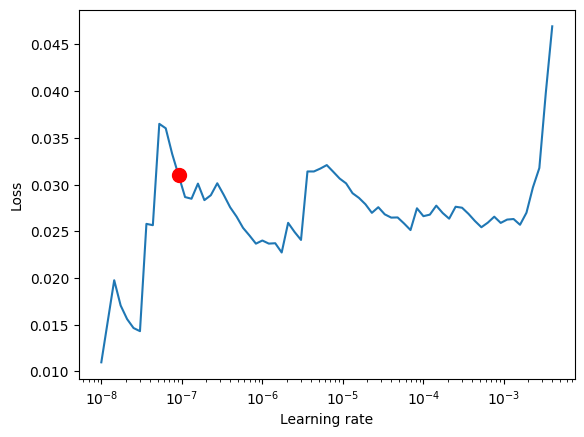

Suggested learning rate: 9.120108393559096e-08


In [61]:
# by using pytorch lightning we're getting some great stuff for free:
# e.g we can tune the learning rate automatically or iteratively look for the largest batch size we can work with...

from lightning.pytorch.tuner import Tuner
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=3,
)

tuner = Tuner(trainer)

# Run the learning rate finder
lr_finder = tuner.lr_find(model)

# Check if lr_finder was successful
if lr_finder.results is not None:
    # Plot the results
    fig = lr_finder.plot(suggest=True)
    plt.show()

    # Print the suggestion
    print(f"Suggested learning rate: {lr_finder.suggestion()}")
else:
    print("Learning rate finder failed to produce results.")